In [1]:
import numpy as np
import pandas as pd

## decorators.py

In [2]:
from vectorbt.utils.decorators import *

In [3]:
# ensure a is a 2D boolean array
@has_type('a', np.ndarray)
@has_dtype('a', np.bool_)
@to_dim2('a')
# ensure b is a number
@has_type('b', (int, float, complex))
# ensure c is the same type as a and force it to be float
@has_type('c', 'a')
@to_dtype('c', np.float64)
# same number of columns for a and c
@broadcast_both('a', 'c')
# same number of columns for d as in a
@broadcast_to('d', 'a')
def h(a, b, c=0, d=1):
    return a, b, c, d

h(np.array([[True], [False], [False], [True], [False]]), 50, c=np.zeros((5, 5)))

(array([[ True,  True,  True,  True,  True],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [ True,  True,  True,  True,  True],
        [False, False, False, False, False]]), 50, array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]), array([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]]))

## TimeSeries

In [4]:
from vectorbt.timeseries import TimeSeries

In [5]:
ts = TimeSeries(pd.DataFrame({
    'a': [1, 2, 3, 4, np.nan], 
    'b': [np.nan, 4, 3, 2, 1],
    'c': [1, 2, 3, 2, 1]}))
ts

TimeSeries([[ 1., nan,  1.],
            [ 2.,  4.,  2.],
            [ 3.,  3.,  3.],
            [ 4.,  2.,  2.],
            [nan,  1.,  1.]])

In [6]:
ts.set_by_mask(np.isnan(ts), -1)

TimeSeries([[ 1., -1.,  1.],
            [ 2.,  4.,  2.],
            [ 3.,  3.,  3.],
            [ 4.,  2.,  2.],
            [-1.,  1.,  1.]])

In [7]:
ts.fillna(-1)

TimeSeries([[ 1., -1.,  1.],
            [ 2.,  4.,  2.],
            [ 3.,  3.,  3.],
            [ 4.,  2.,  2.],
            [-1.,  1.,  1.]])

In [8]:
ts.prepend(3, np.nan)

TimeSeries([[nan, nan, nan],
            [nan, nan, nan],
            [nan, nan, nan],
            [ 1., nan,  1.],
            [ 2.,  4.,  2.],
            [ 3.,  3.,  3.],
            [ 4.,  2.,  2.],
            [nan,  1.,  1.]])

In [9]:
ts.fshift(3)

TimeSeries([[nan, nan, nan],
            [nan, nan, nan],
            [nan, nan, nan],
            [ 1., nan,  1.],
            [ 2.,  4.,  2.]])

In [10]:
ts.pct_change()

TimeSeries([[        nan,         nan,         nan],
            [ 1.        ,         nan,  1.        ],
            [ 0.5       , -0.25      ,  0.5       ],
            [ 0.33333333, -0.33333333, -0.33333333],
            [        nan, -0.5       , -0.5       ]])

In [11]:
ts.ffill()

TimeSeries([[ 1., nan,  1.],
            [ 2.,  4.,  2.],
            [ 3.,  3.,  3.],
            [ 4.,  2.,  2.],
            [ 4.,  1.,  1.]])

In [12]:
ts.rolling_mean(3)

TimeSeries([[1.        ,        nan, 1.        ],
            [1.5       , 4.        , 1.5       ],
            [2.        , 3.5       , 2.        ],
            [3.        , 3.        , 2.33333333],
            [3.5       , 2.        , 2.        ]])

In [13]:
pd.DataFrame(ts).rolling(window=3, min_periods=1).mean()

,0,1,2
0,1.0,NaN,1.000000
1,1.5,4.0,1.500000
2,2.0,3.5,2.000000
3,3.0,3.0,2.333333
4,3.5,2.0,2.000000


In [14]:
ts.ewma(3, True)

TimeSeries([[1.        ,        nan, 1.        ],
            [1.66666667,        nan, 1.66666667],
            [2.42857143,        nan, 2.42857143],
            [3.26666667,        nan, 2.2       ],
            [       nan,        nan, 1.58064516]])

In [15]:
pd.DataFrame(ts).ewm(span=3, min_periods=1, adjust=True).mean()

,0,1,2
0,1.000000,NaN,1.000000
1,1.666667,4.000000,1.666667
2,2.428571,3.333333,2.428571
3,3.266667,2.571429,2.200000
4,3.266667,1.733333,1.580645


In [16]:
ts.cumsum()

TimeSeries([[ 1., nan,  1.],
            [ 3., nan,  3.],
            [ 6., nan,  6.],
            [10., nan,  8.],
            [nan, nan,  9.]])

In [17]:
ts.cumprod()

TimeSeries([[ 1., nan,  1.],
            [ 2., nan,  2.],
            [ 6., nan,  6.],
            [24., nan, 12.],
            [nan, nan, 12.]])

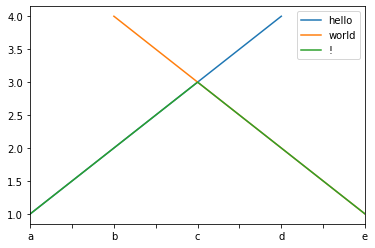

In [18]:
# Two ways of plotting
pd.DataFrame(ts, index=['a', 'b', 'c', 'd', 'e'], columns=['hello', 'world', '!']).plot()

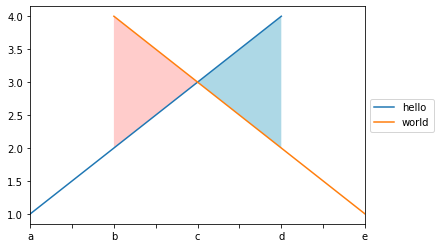

In [19]:
ts[:, 0].plot(benchmark=ts[:, 1], index=['a', 'b', 'c', 'd', 'e'], label='hello', benchmark_label='world')

## Signals

In [20]:
from vectorbt.signals import Signals

In [21]:
Signals.falses((5, 3))

Signals([[False, False, False],
         [False, False, False],
         [False, False, False],
         [False, False, False],
         [False, False, False]])

In [22]:
entries = Signals.generate_random_entries((5, 3), 2, every_nth=2, seed=42)
entries

Signals([[ True,  True,  True],
         [False, False, False],
         [False,  True, False],
         [False, False, False],
         [ True, False,  True]])

In [23]:
Signals.generate_random_exits(entries)

Signals([[False, False, False],
         [ True,  True, False],
         [False, False, False],
         [False,  True,  True],
         [False, False, False]])

In [24]:
entries.generate_random_exits()

Signals([[False, False, False],
         [False,  True, False],
         [ True, False, False],
         [False,  True,  True],
         [False, False, False]])

In [25]:
from numba import njit, b1

@njit
def exit_func_nb(entries, col_idx, prev_idx):
    # First value after entry
    entries = entries[:, col_idx]
    a = np.full(entries.shape, False, dtype=b1)
    a[prev_idx+1:] = True
    return a

entries.generate_exits(exit_func_nb)

Signals([[False, False, False],
         [ True,  True,  True],
         [False, False, False],
         [False,  True, False],
         [False, False, False]])

In [26]:
entries.generate_exits(exit_func_nb, only_first=False)

Signals([[False, False, False],
         [ True,  True,  True],
         [ True, False,  True],
         [ True,  True,  True],
         [False,  True, False]])

In [27]:
a = np.random.randint(-1, 2, size=(5, 3))
a

array([[-1,  0, -1],
       [ 1,  1, -1],
       [-1,  0,  1],
       [ 0, -1,  0],
       [ 1,  0,  1]])

In [28]:
@njit
def entry_func_nb(exits, col_idx, prev_idx, a):
    # First value after last entry
    exits = exits[:, col_idx]
    a = a[:, col_idx]
    entries = np.full(exits.shape, False, dtype=b1)
    entries[a == 1] = True
    return entries

@njit
def exit_func_nb(entries, col_idx, prev_idx, a):
    # First value after last exit
    entries = entries[:, col_idx]
    a = a[:, col_idx]
    exits = np.full(entries.shape, False, dtype=b1)
    exits[a == -1] = True
    return exits

Signals.generate_entries_and_exits(a.shape, entry_func_nb, exit_func_nb, a)

(Signals([[False, False, False],
          [ True,  True, False],
          [False, False,  True],
          [False, False, False],
          [ True, False, False]]), Signals([[False, False, False],
          [False, False, False],
          [ True, False, False],
          [False,  True, False],
          [False, False, False]]))

In [29]:
entries = Signals.generate_random_entries((10, 3), 5, seed=43)
entries

Signals([[ True,  True,  True],
         [ True, False, False],
         [ True, False,  True],
         [False,  True,  True],
         [ True,  True, False],
         [False, False, False],
         [False,  True,  True],
         [False,  True, False],
         [False, False,  True],
         [ True, False, False]])

In [30]:
entries.prepend(2, False)

Signals([[False, False, False],
         [False, False, False],
         [ True,  True,  True],
         [ True, False, False],
         [ True, False,  True],
         [False,  True,  True],
         [ True,  True, False],
         [False, False, False],
         [False,  True,  True],
         [False,  True, False],
         [False, False,  True],
         [ True, False, False]])

In [31]:
entries.fshift(2)

Signals([[False, False, False],
         [False, False, False],
         [ True,  True,  True],
         [ True, False, False],
         [ True, False,  True],
         [False,  True,  True],
         [ True,  True, False],
         [False, False, False],
         [False,  True,  True],
         [False,  True, False]])

In [32]:
entries.first()

Signals([[ True,  True,  True],
         [False, False, False],
         [False, False,  True],
         [False,  True, False],
         [ True, False, False],
         [False, False, False],
         [False,  True,  True],
         [False, False, False],
         [False, False,  True],
         [ True, False, False]])

In [33]:
entries.first_nst(2)

Signals([[False, False, False],
         [ True, False, False],
         [False, False, False],
         [False, False,  True],
         [False,  True, False],
         [False, False, False],
         [False, False, False],
         [False,  True, False],
         [False, False, False],
         [False, False, False]])

In [34]:
entries.from_first_nst(2)

Signals([[False, False, False],
         [ True, False, False],
         [ True, False, False],
         [False, False,  True],
         [False,  True, False],
         [False, False, False],
         [False, False, False],
         [False,  True, False],
         [False, False, False],
         [False, False, False]])

In [35]:
entries.last_nst(2)

Signals([[False, False, False],
         [False, False, False],
         [False,  True, False],
         [False, False, False],
         [False, False, False],
         [False, False,  True],
         [ True, False, False],
         [False, False, False],
         [False, False, False],
         [False,  True, False]])

In [36]:
entries.from_last_nst(2)

Signals([[False, False, False],
         [False, False, False],
         [False,  True, False],
         [False, False, False],
         [False, False, False],
         [False, False,  True],
         [ True, False, False],
         [ True, False, False],
         [ True, False, False],
         [False,  True, False]])

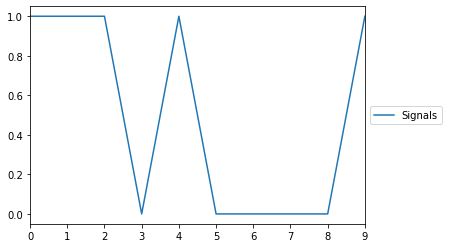

In [37]:
entries[:, 0].plot()

## Positions

In [38]:
from vectorbt.positions import Positions

In [39]:
ts = TimeSeries(np.asarray([
    [1, 9, 1, 5],
    [2, 8, 2, 4],
    [3, 7, 3, 3],
    [4, 6, 4, 2],
    [5, 5, 5, 1],
    [6, 4, 4, 2],
    [7, 3, 3, 3],
    [8, 2, 2, 4],
    [9, 1, 1, 5]
], dtype=np.float64))
ts

TimeSeries([[1., 9., 1., 5.],
            [2., 8., 2., 4.],
            [3., 7., 3., 3.],
            [4., 6., 4., 2.],
            [5., 5., 5., 1.],
            [6., 4., 4., 2.],
            [7., 3., 3., 3.],
            [8., 2., 2., 4.],
            [9., 1., 1., 5.]])

In [40]:
entries = Signals(np.asarray([
    [True, True, True, True],
    [False, False, False, False],
    [False, False, False, False],
    [True, True, True, True],
    [False, False, False, False],
    [False, False, False, False],
    [True, True, True, True],
    [False, False, False, False],
    [False, False, False, False]
]))
entries

Signals([[ True,  True,  True,  True],
         [False, False, False, False],
         [False, False, False, False],
         [ True,  True,  True,  True],
         [False, False, False, False],
         [False, False, False, False],
         [ True,  True,  True,  True],
         [False, False, False, False],
         [False, False, False, False]])

In [41]:
exits = entries.fshift(2)
exits

Signals([[False, False, False, False],
         [False, False, False, False],
         [ True,  True,  True,  True],
         [False, False, False, False],
         [False, False, False, False],
         [ True,  True,  True,  True],
         [False, False, False, False],
         [False, False, False, False],
         [ True,  True,  True,  True]])

In [42]:
positions = Positions.from_signals(entries, exits)
positions

Positions([[ 1,  1,  1,  1],
           [ 0,  0,  0,  0],
           [-1, -1, -1, -1],
           [ 1,  1,  1,  1],
           [ 0,  0,  0,  0],
           [-1, -1, -1, -1],
           [ 1,  1,  1,  1],
           [ 0,  0,  0,  0],
           [-1, -1, -1, -1]], dtype=int8)

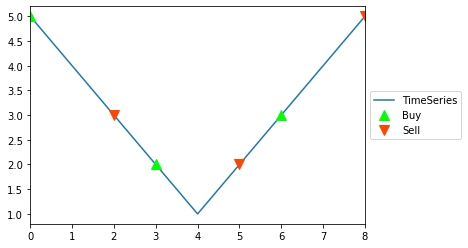

In [43]:
positions[:, 3].plot(ts=ts[:, 3])

## Portfolio

In [44]:
from vectorbt.portfolio import Portfolio

In [45]:
portfolio = Portfolio(ts, positions, investment=100.)

In [46]:
portfolio.equity

TimeSeries([[100.        , 100.        , 100.        , 100.        ],
            [200.        ,  88.88888889, 200.        ,  80.        ],
            [300.        ,  77.77777778, 300.        ,  60.        ],
            [300.        ,  77.77777778, 300.        ,  60.        ],
            [375.        ,  64.81481481, 375.        ,  30.        ],
            [450.        ,  51.85185185, 300.        ,  60.        ],
            [450.        ,  51.85185185, 300.        ,  60.        ],
            [514.28571429,  34.56790123, 200.        ,  80.        ],
            [578.57142857,  17.28395062, 100.        , 100.        ]])

In [47]:
portfolio.equity_in_shares

TimeSeries([[100.        ,  11.11111111, 100.        ,  20.        ],
            [100.        ,  11.11111111, 100.        ,  20.        ],
            [100.        ,  11.11111111, 100.        ,  20.        ],
            [ 75.        ,  12.96296296,  75.        ,  30.        ],
            [ 75.        ,  12.96296296,  75.        ,  30.        ],
            [ 75.        ,  12.96296296,  75.        ,  30.        ],
            [ 64.28571429,  17.28395062, 100.        ,  20.        ],
            [ 64.28571429,  17.28395062, 100.        ,  20.        ],
            [ 64.28571429,  17.28395062, 100.        ,  20.        ]])

In [48]:
portfolio.returns

TimeSeries([[ 0.        ,  0.        ,  0.        ,  0.        ],
            [ 1.        , -0.11111111,  1.        , -0.2       ],
            [ 0.5       , -0.125     ,  0.5       , -0.25      ],
            [ 0.        ,  0.        ,  0.        ,  0.        ],
            [ 0.25      , -0.16666667,  0.25      , -0.5       ],
            [ 0.2       , -0.2       , -0.2       ,  1.        ],
            [ 0.        ,  0.        ,  0.        ,  0.        ],
            [ 0.14285714, -0.33333333, -0.33333333,  0.33333333],
            [ 0.125     , -0.5       , -0.5       ,  0.25      ]])

In [49]:
portfolio.trade_profits

TimeSeries([[   0.        ,    0.        ,    0.        ,    0.        ],
            [   0.        ,    0.        ,    0.        ,    0.        ],
            [ 200.        ,  -22.22222222,  200.        ,  -40.        ],
            [   0.        ,    0.        ,    0.        ,    0.        ],
            [   0.        ,    0.        ,    0.        ,    0.        ],
            [ 150.        ,  -25.92592593,    0.        ,    0.        ],
            [   0.        ,    0.        ,    0.        ,    0.        ],
            [   0.        ,    0.        ,    0.        ,    0.        ],
            [ 128.57142857,  -34.56790123, -200.        ,   40.        ]])

In [50]:
portfolio.trade_returns

TimeSeries([[ 0.        ,  0.        ,  0.        ,  0.        ],
            [ 0.        ,  0.        ,  0.        ,  0.        ],
            [ 2.        , -0.22222222,  2.        , -0.4       ],
            [ 0.        ,  0.        ,  0.        ,  0.        ],
            [ 0.        ,  0.        ,  0.        ,  0.        ],
            [ 0.5       , -0.33333333,  0.        ,  0.        ],
            [ 0.        ,  0.        ,  0.        ,  0.        ],
            [ 0.        ,  0.        ,  0.        ,  0.        ],
            [ 0.28571429, -0.66666667, -0.66666667,  0.66666667]])

In [51]:
portfolio.avg_win

array([159.52380952,   0.        , 200.        ,  40.        ])

In [52]:
portfolio.avg_loss

array([  0.        ,  27.57201646, 200.        ,  40.        ])

In [53]:
portfolio.win_prob

array([1. , 0. , 0.5, 0.5])

In [54]:
portfolio.loss_prob

array([0. , 1. , 0.5, 0.5])

In [55]:
portfolio.appt

array([159.52380952, -27.57201646,   0.        ,   0.        ])

In [56]:
portfolio.total_net_profit

array([478.57142857, -82.71604938,   0.        ,   0.        ])

In [57]:
portfolio.profit_factor

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio.py:166: RuntimeWarning: divide by zero encountered in true_divide
  return self.sum_win / self.sum_loss


array([inf,  0.,  1.,  1.])

In [58]:
portfolio.mdd

TimeSeries([0.        , 0.82716049, 0.73333333, 0.7       ])